Loading images from C:\Users\PMLS\Desktop\Notes and Assignments 7\Machine Learning\OCR\mnist_data\train-images.idx3-ubyte
Loading labels from C:\Users\PMLS\Desktop\Notes and Assignments 7\Machine Learning\OCR\mnist_data\train-labels.idx1-ubyte
Loading images from C:\Users\PMLS\Desktop\Notes and Assignments 7\Machine Learning\OCR\mnist_data\t10k-images.idx3-ubyte
Loading labels from C:\Users\PMLS\Desktop\Notes and Assignments 7\Machine Learning\OCR\mnist_data\t10k-labels.idx1-ubyte
Epoch 1/20, Loss: 0.4376, Accuracy: 86.67%
Epoch 2/20, Loss: 0.3541, Accuracy: 89.06%
Epoch 3/20, Loss: 0.2867, Accuracy: 90.06%
Epoch 4/20, Loss: 0.1948, Accuracy: 90.72%
Epoch 5/20, Loss: 0.2524, Accuracy: 91.38%
Epoch 6/20, Loss: 0.1845, Accuracy: 91.69%
Epoch 7/20, Loss: 0.3104, Accuracy: 92.09%
Epoch 8/20, Loss: 0.1769, Accuracy: 92.43%
Epoch 9/20, Loss: 0.1210, Accuracy: 92.74%
Epoch 10/20, Loss: 0.1512, Accuracy: 92.96%
Epoch 11/20, Loss: 0.3263, Accuracy: 93.04%
Epoch 12/20, Loss: 0.1005, Accuracy: 93

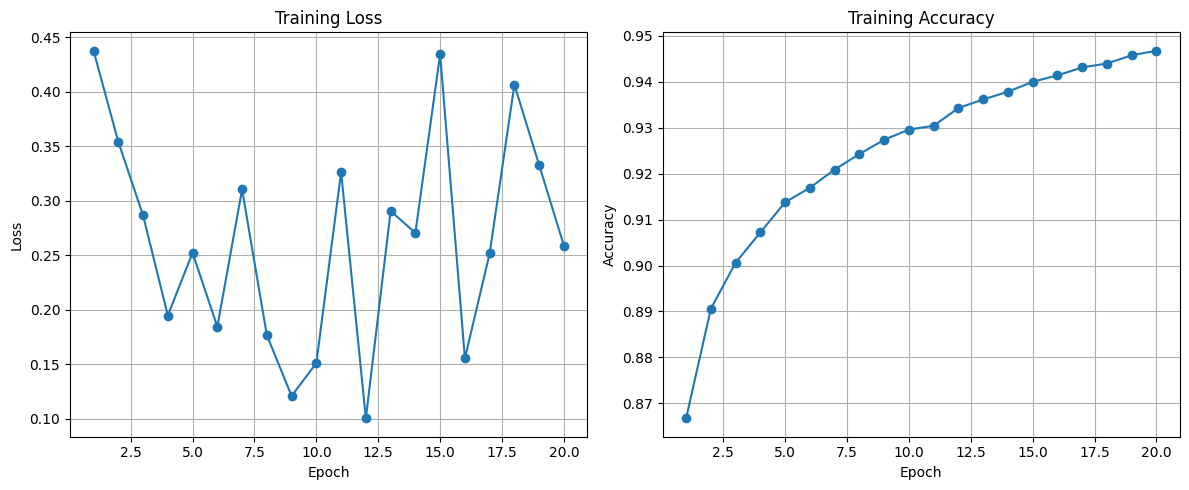

Model saved to C:\Users\PMLS\Desktop\Notes and Assignments 7\Machine Learning\OCR


In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import os
from PIL import Image

# Directories
data_dir = r'C:\Users\PMLS\Desktop\Notes and Assignments 7\Machine Learning\OCR\mnist_data'
save_directory = r'C:\Users\PMLS\Desktop\Notes and Assignments 7\Machine Learning\OCR'

# Ensure save directory exists
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Load MNIST data functions
def load_mnist_images(filename):
    filepath = os.path.join(data_dir, filename)
    print(f"Loading images from {filepath}")
    with open(filepath, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows * cols)
        images = images / 255.0  # Normalize pixel values
    return images

def load_mnist_labels(filename):
    filepath = os.path.join(data_dir, filename)
    print(f"Loading labels from {filepath}")
    with open(filepath, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels


def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot


def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Numerical stability
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)


def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)

    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)

    cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    return A2, cache


def compute_loss(A2, Y):
    m = Y.shape[0]
    log_probs = -np.log(A2 + 1e-8) * Y  # Add epsilon to avoid log(0)
    loss = np.sum(log_probs) / m
    return loss


def backward_propagation(X, Y, cache, W2):
    m = X.shape[0]
    Z1 = cache['Z1']
    A1 = cache['A1']
    A2 = cache['A2']


    dZ2 = A2 - Y  

    dW2 = np.dot(A1.T, dZ2) / m  
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m  

    
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)  

    
    dW1 = np.dot(X.T, dZ1) / m  
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m  

    grads = {'dW1': dW1, 'db1': db1,
             'dW2': dW2, 'db2': db2}
    return grads


def update_parameters(W1, b1, W2, b2, grads, learning_rate):
    W1 -= learning_rate * grads['dW1']
    b1 -= learning_rate * grads['db1']
    W2 -= learning_rate * grads['dW2']
    b2 -= learning_rate * grads['db2']
    return W1, b1, W2, b2


X_train = load_mnist_images('train-images.idx3-ubyte')
y_train = load_mnist_labels('train-labels.idx1-ubyte')
X_test = load_mnist_images('t10k-images.idx3-ubyte')
y_test = load_mnist_labels('t10k-labels.idx1-ubyte')

y_train_encoded = one_hot_encode(y_train, 10)
y_test_encoded = one_hot_encode(y_test, 10)


input_size = 784 #Because 28x28 images are being flattened into a vector so we set input neurons to 784
hidden_size = 64 #This is the no. of hidden layers. We can change it as well
output_size = 10 #Since we are only checking digits from 0 to 9 so we set the output neurons to be 10

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
b2 = np.zeros((1, output_size))

# Hyperparameters
learning_rate = 0.01
num_epochs = 20
batch_size = 64

num_batches = X_train.shape[0] // batch_size
losses = []
accuracies = []

# Training loop
for epoch in range(num_epochs):
    permutation = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_encoded_shuffled = y_train_encoded[permutation]

    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_encoded_shuffled[start:end]

        A2, cache = forward_propagation(X_batch, W1, b1, W2, b2)

        loss = compute_loss(A2, y_batch)

        grads = backward_propagation(X_batch, y_batch, cache, W2)

        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, grads, learning_rate)


    A2_full, _ = forward_propagation(X_train, W1, b1, W2, b2)
    predictions = np.argmax(A2_full, axis=1)
    labels = y_train
    accuracy = np.mean(predictions == labels)


    losses.append(loss)
    accuracies.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%")


A2_test, _ = forward_propagation(X_test, W1, b1, W2, b2)
test_predictions = np.argmax(A2_test, axis=1)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


plt.figure(figsize=(12, 5))

# Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the trained model
np.savez(os.path.join(save_directory, 'trained_model.npz'),
         W1=W1, b1=b1, W2=W2, b2=b2)
print(f"Model saved to {save_directory}")


def load_custom_image(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((28, 28))
    img = np.invert(img)
    img_array = np.array(img) / 255.0
    img_flatten = img_array.flatten().reshape(1, -1)
    return img_flatten

def predict_image(image, W1, b1, W2, b2):
    A2, _ = forward_propagation(image, W1, b1, W2, b2)
    prediction = np.argmax(A2, axis=1)
    return prediction

# Example usage with custom image (Uncomment and update the path to use)
# custom_image = load_custom_image('path_to_your_image.png')
# prediction = predict_image(custom_image, W1, b1, W2, b2)
# print(f"Predicted Digit: {prediction[0]}")


Model parameters loaded from C:\Users\PMLS\Desktop\Notes and Assignments 7\Machine Learning\OCR\trained_model.npz
Original image size: (920, 920)
Resized image size: (28, 28)
Image array shape after conversion: (28, 28)
Flattened image shape: (1, 784)


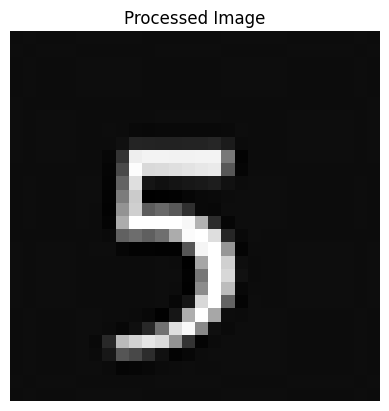

Predicted Digit: 5


In [3]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the directory where the model is saved
save_directory = r'C:\Users\PMLS\Desktop\Notes and Assignments 7\Machine Learning\OCR'

# Load the saved model parameters
def load_model_parameters(save_directory):
    model_path = os.path.join(save_directory, 'trained_model.npz')
    with np.load(model_path) as data:
        W1 = data['W1']
        b1 = data['b1']
        W2 = data['W2']
        b2 = data['b2']
    print(f"Model parameters loaded from {model_path}")
    return W1, b1, W2, b2

# Activation functions
def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Numerical stability
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

# Forward propagation
def forward_propagation(X, W1, b1, W2, b2):
    # Hidden layer
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    
    # Output layer
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    
    return A2

# Function to load and preprocess custom images
def load_custom_image(image_path):
    # Open the image and convert to grayscale
    img = Image.open(image_path).convert('L')
    print(f"Original image size: {img.size}")
    
    # Resize to 28x28 pixels
    img = img.resize((28, 28))
    print(f"Resized image size: {img.size}")
    
    # Invert colors (if necessary)
    img = np.invert(img)
    
    # Convert to numpy array and normalize
    img_array = np.array(img) / 255.0
    print(f"Image array shape after conversion: {img_array.shape}")
    
    # Flatten the image
    img_flatten = img_array.flatten().reshape(1, -1)
    print(f"Flattened image shape: {img_flatten.shape}")
    
    # Display the image
    plt.imshow(img_array, cmap='gray')
    plt.title('Processed Image')
    plt.axis('off')
    plt.show()
    
    return img_flatten

# Function to predict custom images
def predict_image(image, W1, b1, W2, b2):
    # Forward propagation
    A2 = forward_propagation(image, W1, b1, W2, b2)
    prediction = np.argmax(A2, axis=1)
    return prediction

# Load the model parameters
W1, b1, W2, b2 = load_model_parameters(save_directory)

# Path to your custom image
image_path = r'C:\Users\PMLS\Desktop\Notes and Assignments 7\Machine Learning\OCR\images2.png'  # Replace with your image path

# Load and preprocess your image
custom_image = load_custom_image(image_path)

# Make a prediction
prediction = predict_image(custom_image, W1, b1, W2, b2)
print(f"Predicted Digit: {prediction[0]}")
